# Instructions

- Developed on Google Colab, not tested locally
- Add a 'caliper' and 'plots' folder to your MyDrive
- You must mount your drive to this instance to gain access to your MyDrive
   (see folder icon under 'Files')

In [4]:
# Developed on Google Cloud, uncomment to get correct version
# !pip install llnl-thicket==2024.1.0 -q

# Flags

In [472]:
SAVE_PLOTS = False
PRINT_PLOTS = False
PRINT_DF = False

# Read Cali files

In [468]:
import sys
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import thicket as th
import os
import re
from IPython.display import display

# Define the path to your caliper folder in Google Drive
caliper_folder = '/content/drive/My Drive/caliper/'

if not os.path.exists(caliper_folder):
    print(f"The folder '{caliper_folder}' does not exist. (Create path and add cali files)")
    sys.exit(1)

# Read the .cali files using Thicket
cali_files = glob(os.path.join(caliper_folder, "*.cali"))
print(f"Found {len(cali_files)} cali files.")

tk_perm = th.Thicket.from_caliperreader(cali_files)

Found 159 cali files.


(2/2) Creating Thicket: 100%|██████████| 158/158 [00:01<00:00, 85.00it/s]
/usr/local/lib/python3.10/dist-packages/thicket/ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


# Add Data



In [473]:
tk = tk_perm.copy()
input_type_mapping = {
    "0": "sorted",
    "1": "random",
    "2": "reverse sorted",
    "3": "perturbed"
}

num_procs_list = []
input_size_list = []
input_type_list = []
for file in cali_files:
  file = file.split('/')[-1].split('.')[0]
  match = re.match(r'p(\d+)-a(\d+)-(\d+)', file)
  if match:
    num_procs = int(match.group(1))
    input_size = int(match.group(2))
    input_type = input_type_mapping.get(match.group(3))
    num_procs_list.append(num_procs)
    input_size_list.append(input_size)
    input_type_list.append(input_type)

new_data = pd.DataFrame({
    'num_procs': num_procs_list,
    'input_size': input_size_list,
    'input_type': input_type_list
})

# Repeat otherwise won't fill all rows
#-------
repeated_data = pd.concat([new_data] * 18, ignore_index=True).iloc[:len(tk.dataframe)]
repeated_data.index = tk.dataframe.index
tk.dataframe = tk.dataframe.join(repeated_data)
#-------



# Not needed but makes it easier to look at
#-------
for column in ['num_procs', 'input_size', 'input_type']:
    if column in tk.metadata:
        tk.metadata = tk.metadata.drop(columns=[column])

for column in ['Calls/rank (min)', 'Calls/rank (avg)', 'Calls/rank (max)',
               'Calls/rank (total)', 'spot.channel', 'nid',
               'Min time/rank (exc)', 'Max time/rank (exc)',
               'Avg time/rank (exc)', 'Total time (exc)']:
    if column in tk.dataframe.columns:
        tk.dataframe = tk.dataframe.drop(columns=[column])

#-------

dataframe_dict = {}
for node_name, group in tk.dataframe.groupby('name'):
    if node_name in ['comm', 'main', 'comp_large']:
        dataframe_dict[node_name] = group.copy()

# Calculate Speedup
#-------
for node_name, df in dataframe_dict.items():
    df['Speedup'] = None
    for num_procs, proc_group in df.groupby(['input_type', 'input_size']):
        proc_group = proc_group.sort_values(by='num_procs')

        # drop rows with only one data point
        if len(proc_group) <= 1:
            df.drop(proc_group.index, inplace=True)
            continue

        base_time = proc_group.iloc[0]['Total time'] * 2.0
        proc_group['Speedup'] = base_time / proc_group['Total time']
        df.update(proc_group)
#-------

if PRINT_DF:
    for node_name, df in dataframe_dict.items():
        print(f"Node: {node_name}")
        for input_type, input_type_group in df.groupby('input_type'):
            print(f"  Input Type: {input_type}")
            for input_size, input_size_group in input_type_group.groupby('input_size'):
                print(f"    Input Size: {input_size}")
                display(input_size_group[['num_procs', 'Total time', 'Speedup']])

# Weak Scaling

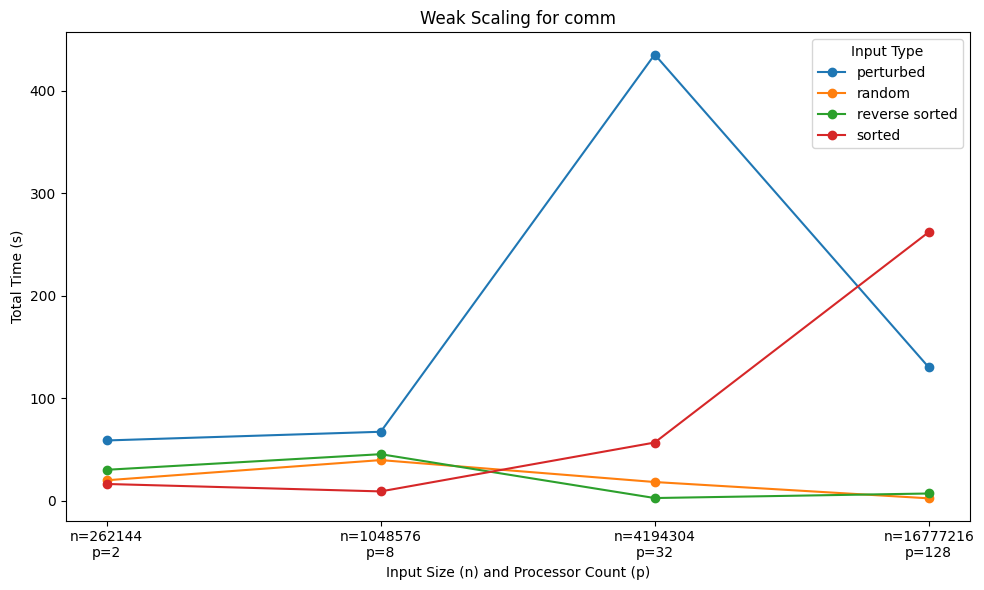

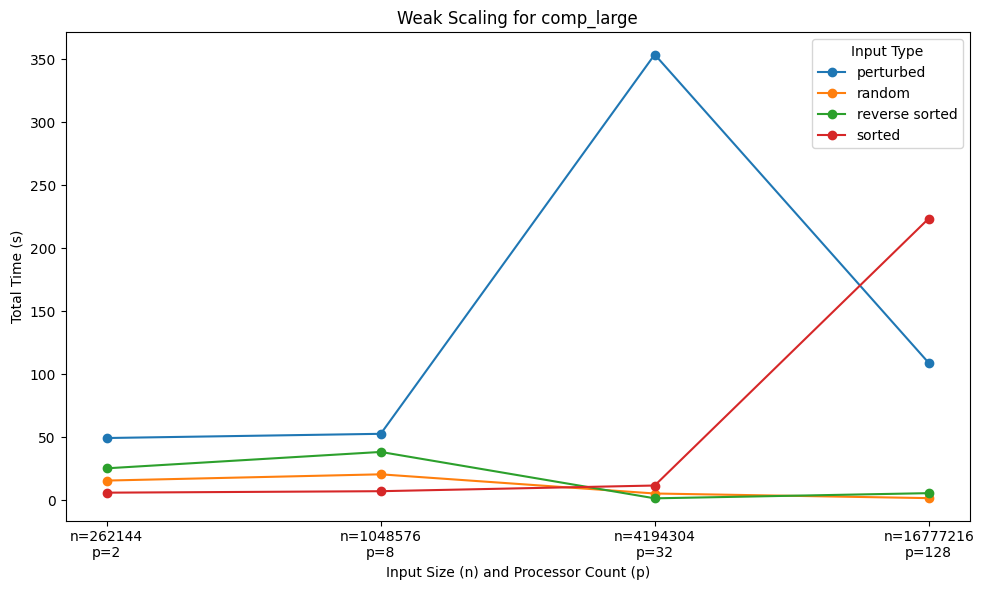

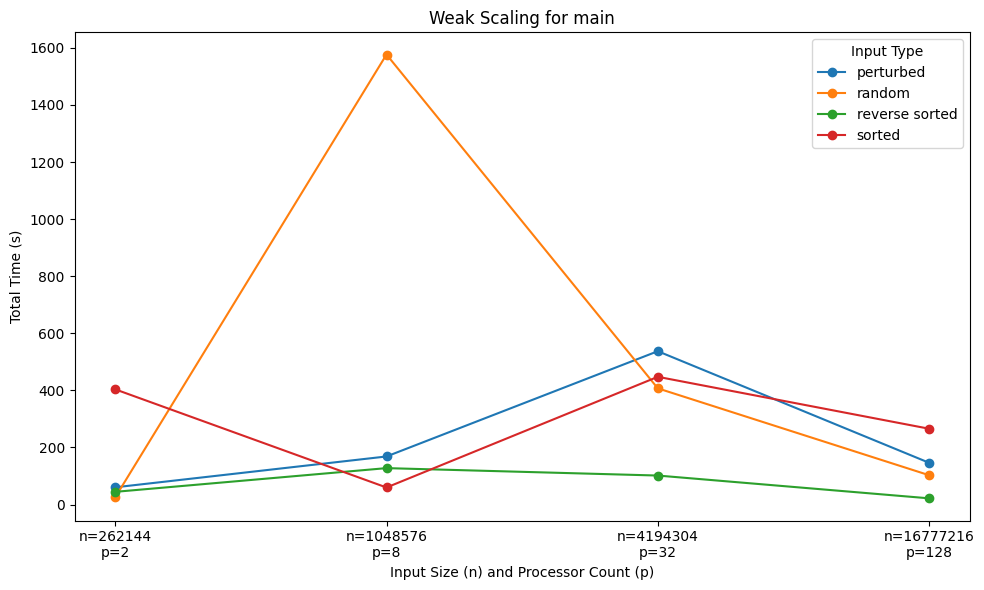

In [474]:
#=======
# AI generated
#=======

def plot_weak_scaling(dataframe_dict):
    np_pairs = [(2**18, 2), (2**20, 8), (2**22, 32), (2**24, 128), (2**26, 512)]  # Scaling pairs (input_size, num_procs)
    x_labels = ['n={}\np={}'.format(n, p) for n, p in np_pairs]  # Labels for the x-axis

    for node_name, df in dataframe_dict.items():
        if node_name not in ['comm', 'main', 'comp_large']:
            continue

        fig, ax = plt.subplots(figsize=(10, 6))
        for input_type, input_type_group in df.groupby('input_type'):
            weak_scaling_times = []

            # Collect Total time for weak scaling
            for input_size, num_procs in np_pairs:
                # Filter by input_size and num_procs
                subset = input_type_group[(input_type_group['input_size'] == input_size) &
                                          (input_type_group['num_procs'] == num_procs)]

                # Take the mean Total time if there are multiple measurements
                if not subset.empty:
                    avg_time = subset['Total time'].mean()
                    weak_scaling_times.append(avg_time)
                else:
                    weak_scaling_times.append(None)  # If no data available, add None for missing points

            # Plot the weak scaling times for this input_type
            ax.plot(x_labels, weak_scaling_times, marker='o', label=f'{input_type}')

        # Formatting the plot
        ax.set_title(f"Weak Scaling for {node_name}")
        ax.set_xlabel("Input Size (n) and Processor Count (p)")
        ax.set_ylabel("Total Time (s)")
        ax.legend(title="Input Type")
        plt.tight_layout()

        if SAVE_PLOTS:
            filename = f"Weak_Scaling_{node_name}.png"
            plt.savefig(f'/content/drive/MyDrive/plots/{filename}', format='png')
            print(f"Saved '{filename}' to /content/drive/MyDrive/plots")
        if PRINT_PLOTS:
            plt.show()

        plt.close(fig)

# Run the function with your dataframe_dict
plot_weak_scaling(dataframe_dict)


# Strong Scaling

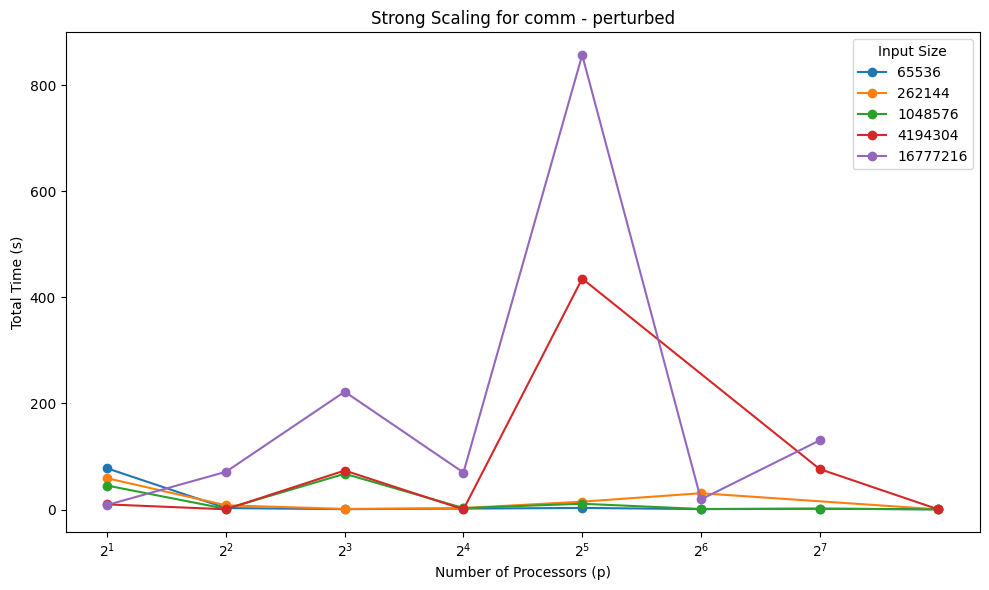

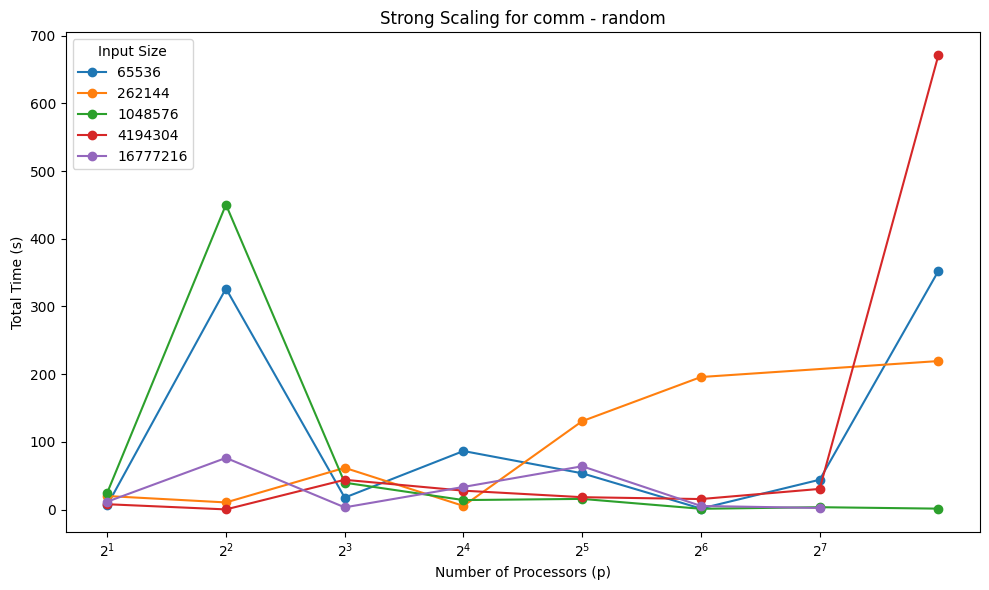

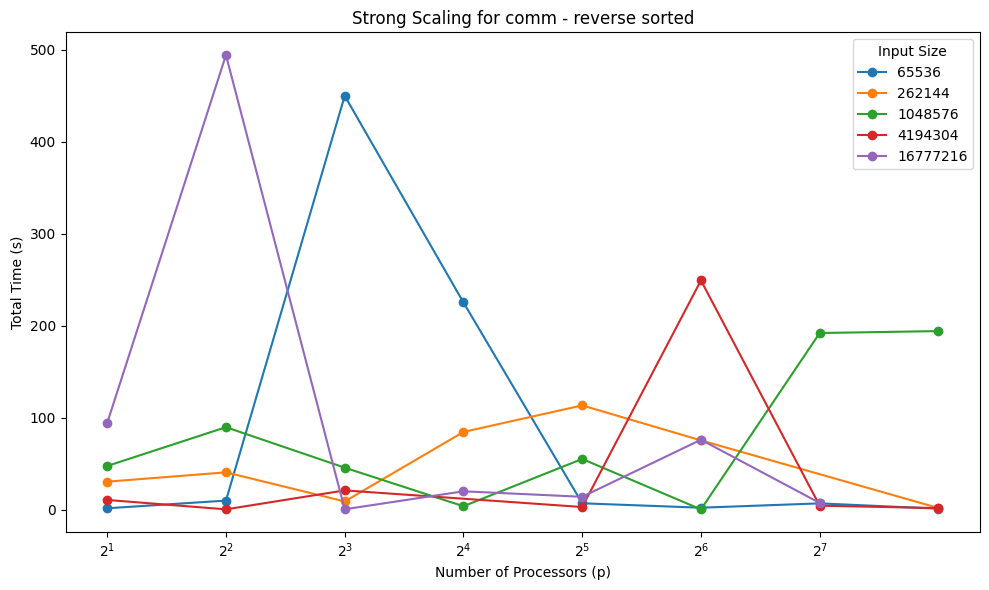

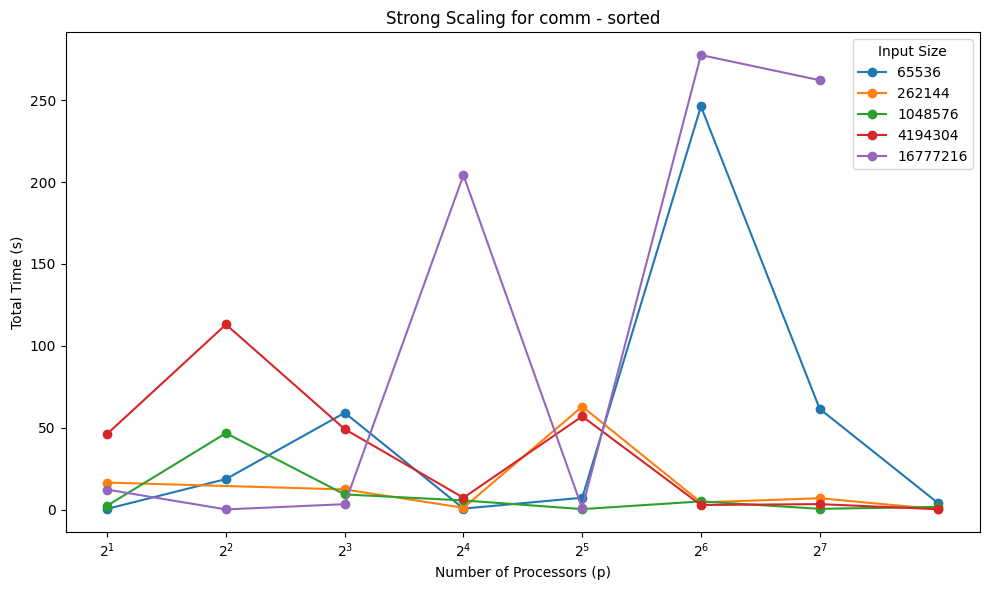

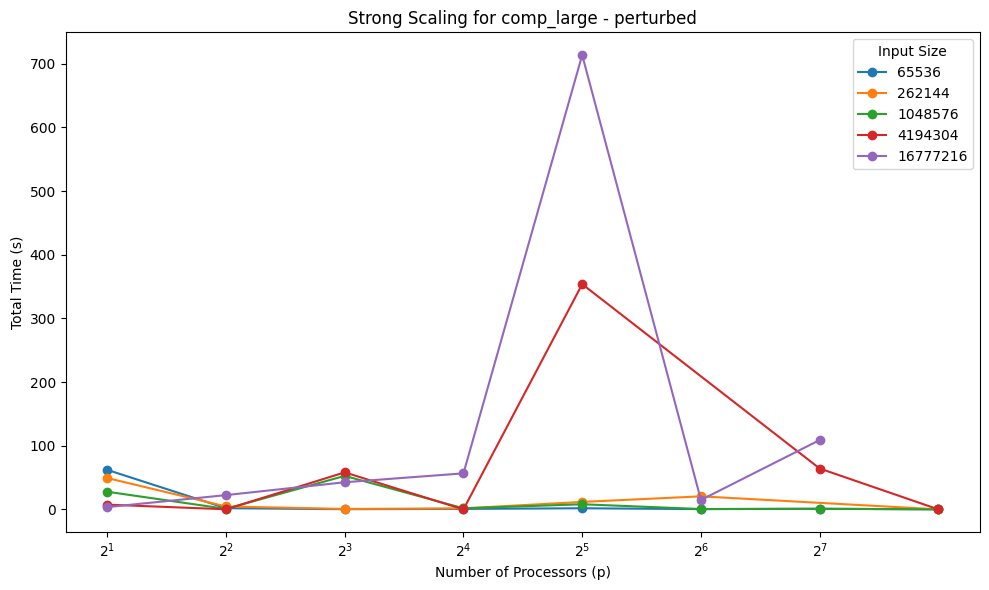

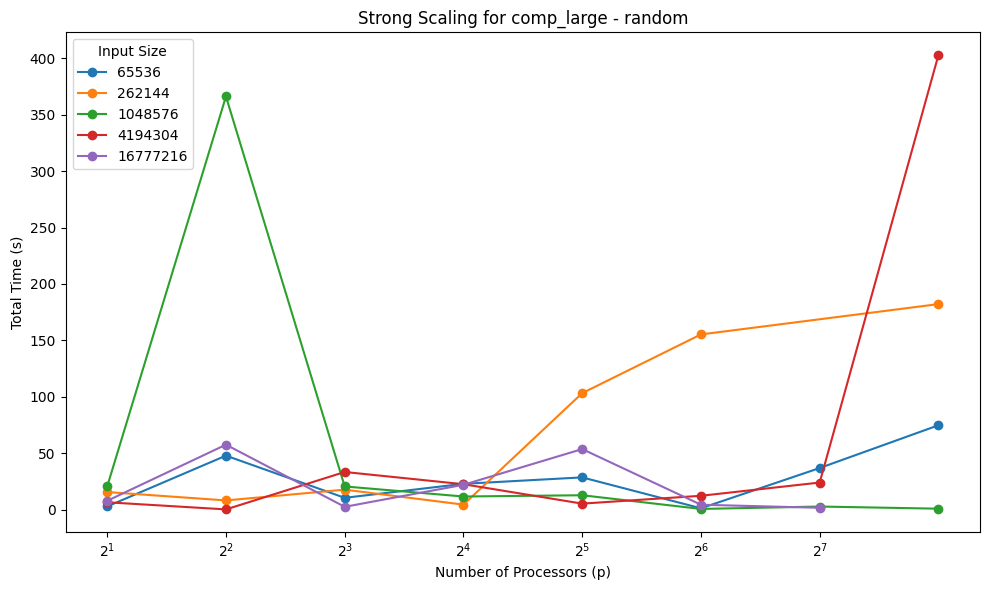

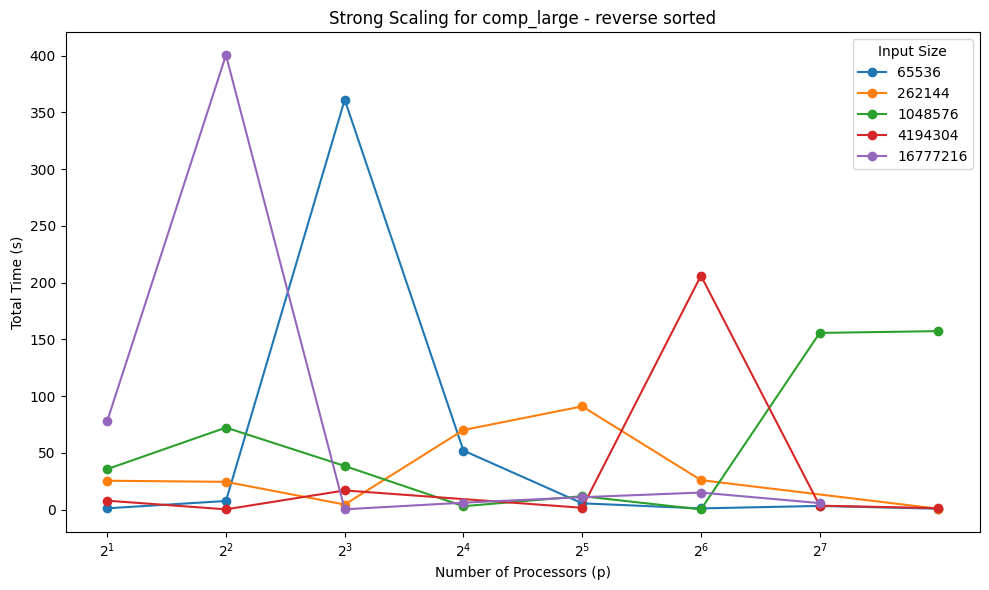

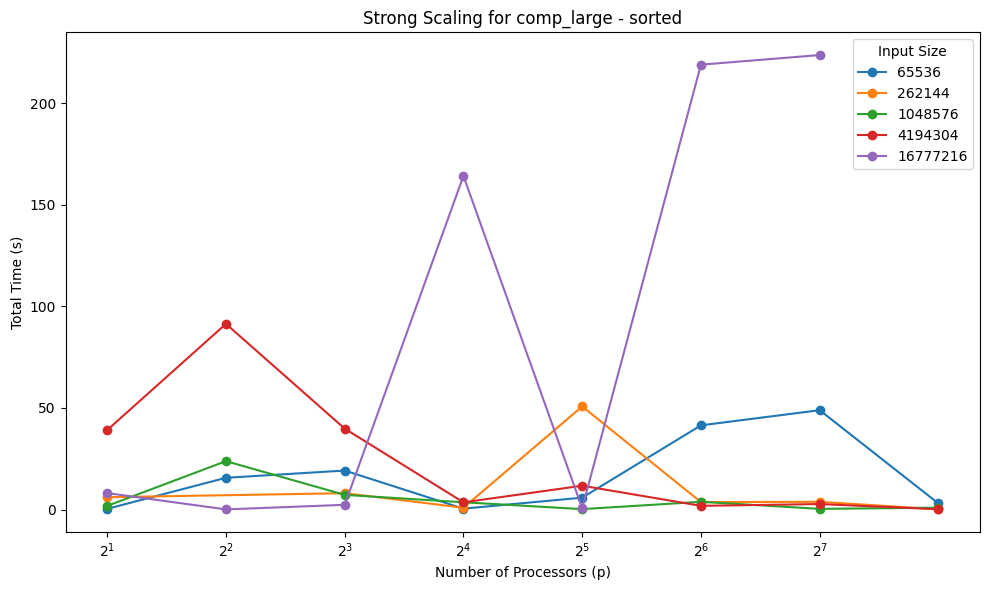

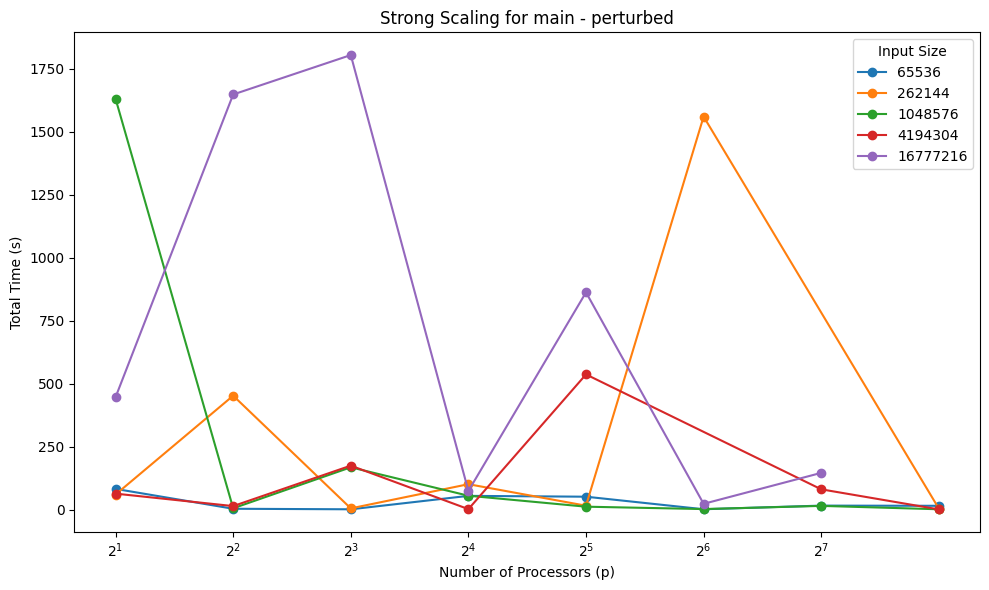

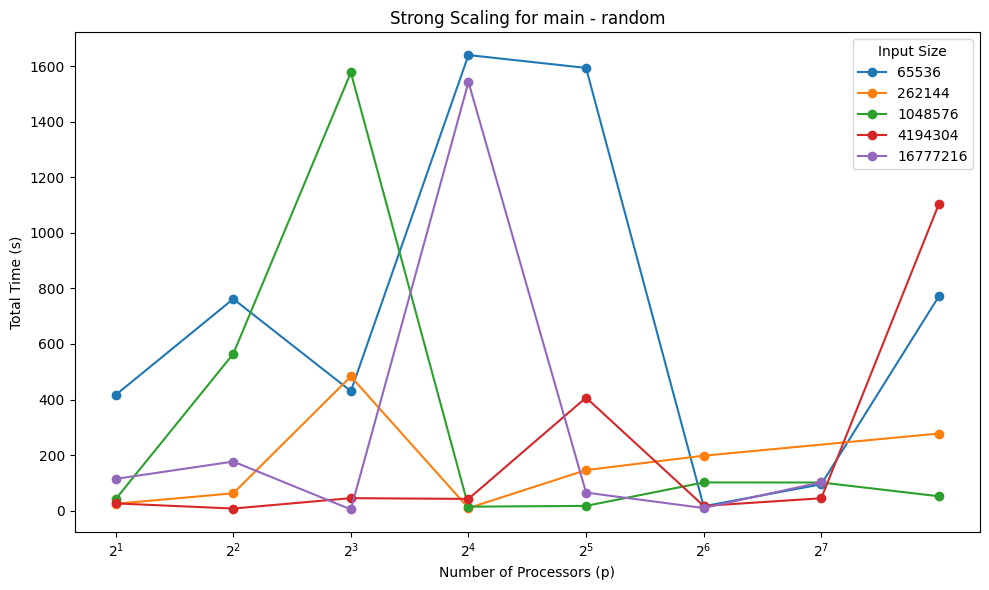

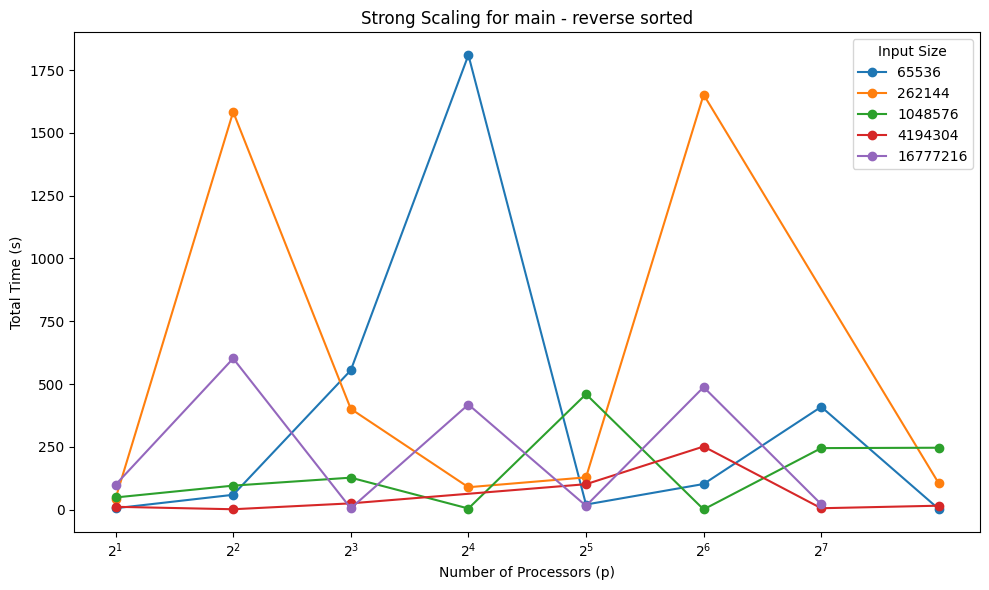

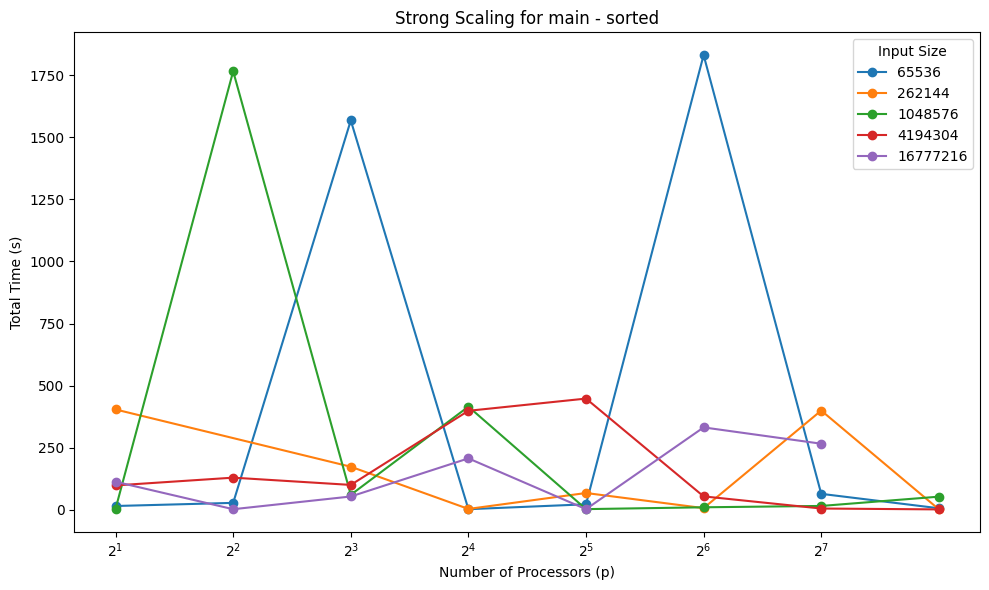

In [475]:
#=======
# AI generated
#=======

def plot_strong_scaling_all_input_sizes(dataframe_dict):
    for node_name, df in dataframe_dict.items():
        if node_name not in ['comm', 'main', 'comp_large']:
            continue

        # Iterate over each input type to create separate plots
        for input_type, input_type_group in df.groupby('input_type'):
            fig, ax = plt.subplots(figsize=(10, 6))

            # Plot strong scaling for each input_size within the same input_type
            for input_size, input_size_group in input_type_group.groupby('input_size'):
                x_labels = sorted(input_size_group['num_procs'].unique())  # Unique num_procs values for the x-axis
                strong_scaling_times = []

                # Collect Total time for different num_procs values for this input_size
                for num_procs in x_labels:
                    time_for_procs = input_size_group[input_size_group['num_procs'] == num_procs]['Total time'].mean()
                    strong_scaling_times.append(time_for_procs)

                # Plot the strong scaling times for this input_size
                ax.plot(x_labels, strong_scaling_times, marker='o', label=f'{input_size}')

            # Formatting the plot
            ax.set_title(f"Strong Scaling for {node_name} - {input_type}")
            ax.set_xscale('log', base=2)
            ax.set_xlabel("Number of Processors (p)")
            ax.set_ylabel("Total Time (s)")
            ax.set_xticks(x_labels)
            ax.legend(title="Input Size")
            plt.tight_layout()

            # Save the plot with a unique filename
            if SAVE_PLOTS:
                filename = f"Strong_Scaling_{node_name}_{input_type}.png"
                plt.savefig(f'/content/drive/MyDrive/plots/{filename}', format='png')
                print(f"Saved '{filename}' to /content/drive/MyDrive/plots")
            if PRINT_PLOTS:
                plt.show()
            plt.close(fig)

# Run the function with your dataframe_dict
plot_strong_scaling_all_input_sizes(dataframe_dict)

# Clock Time

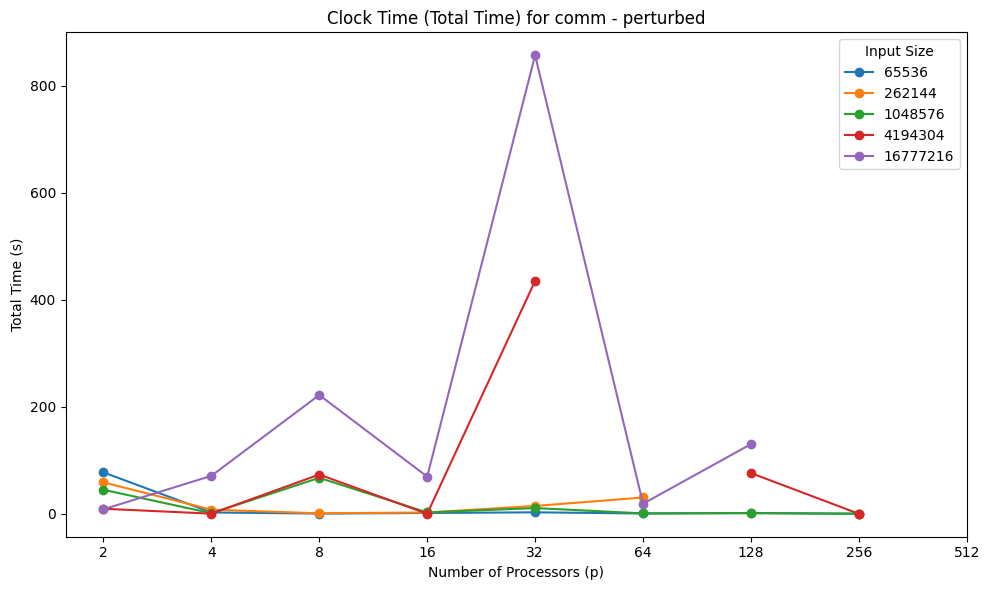

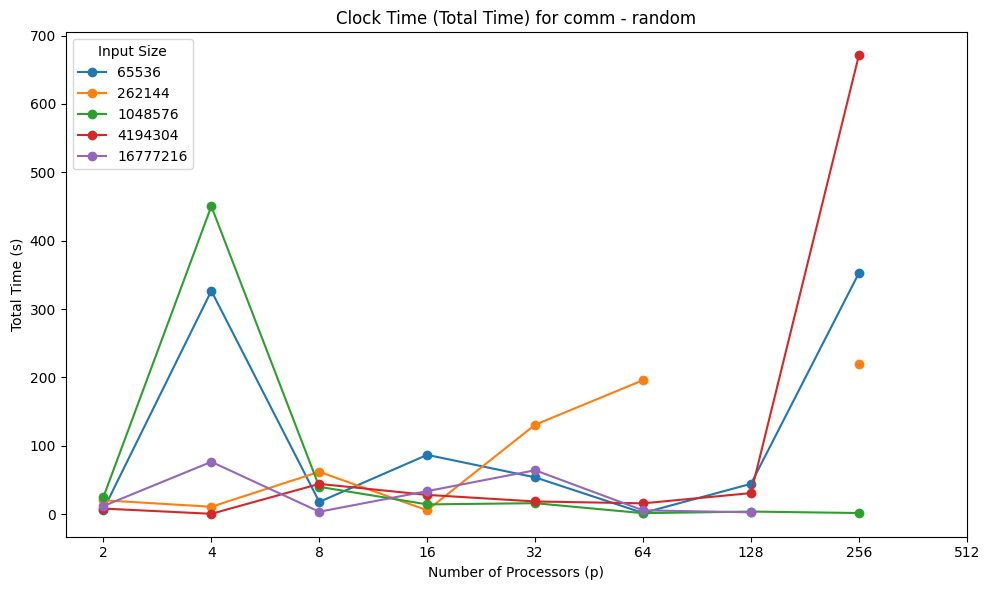

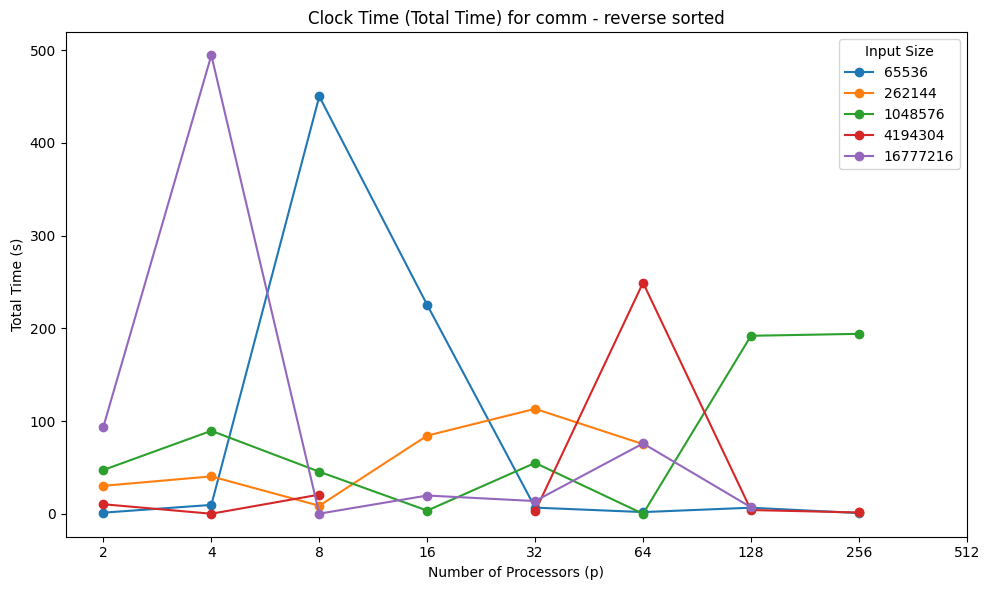

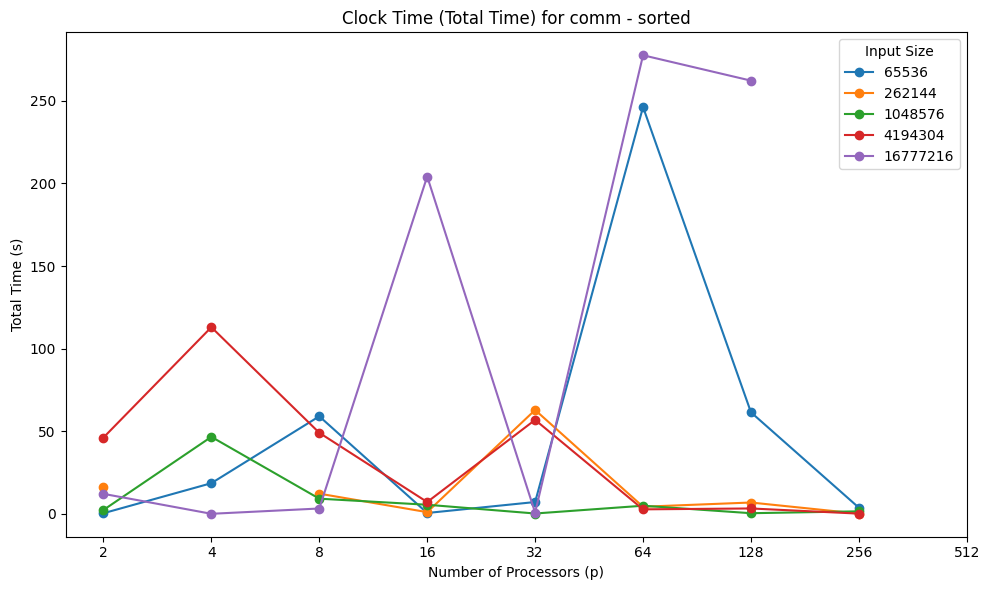

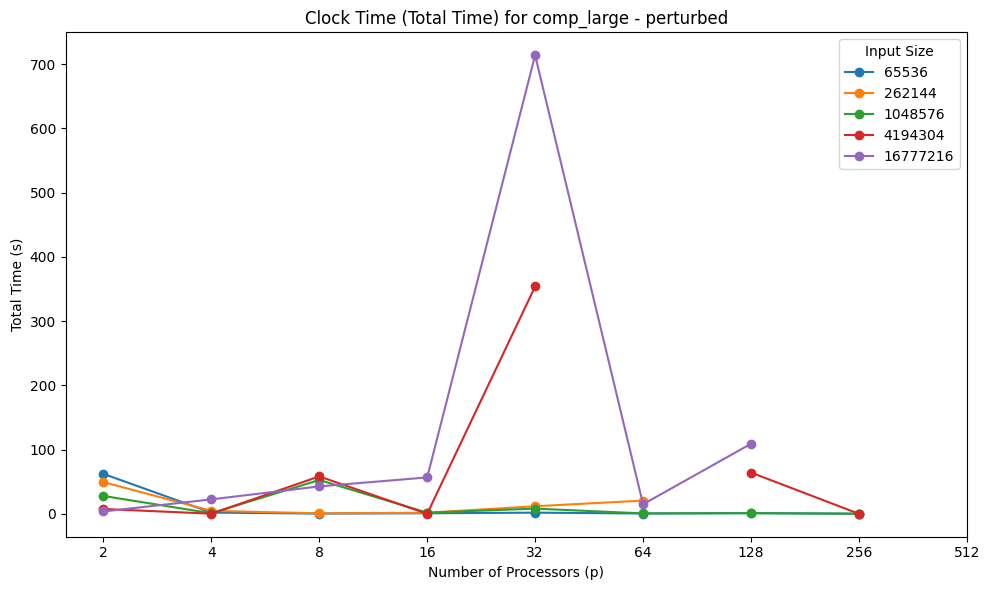

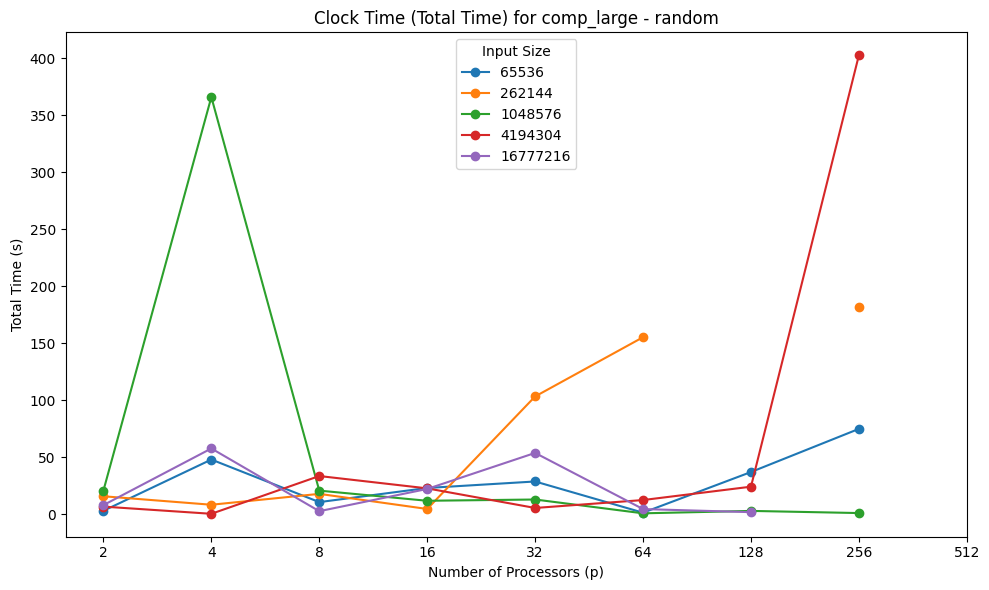

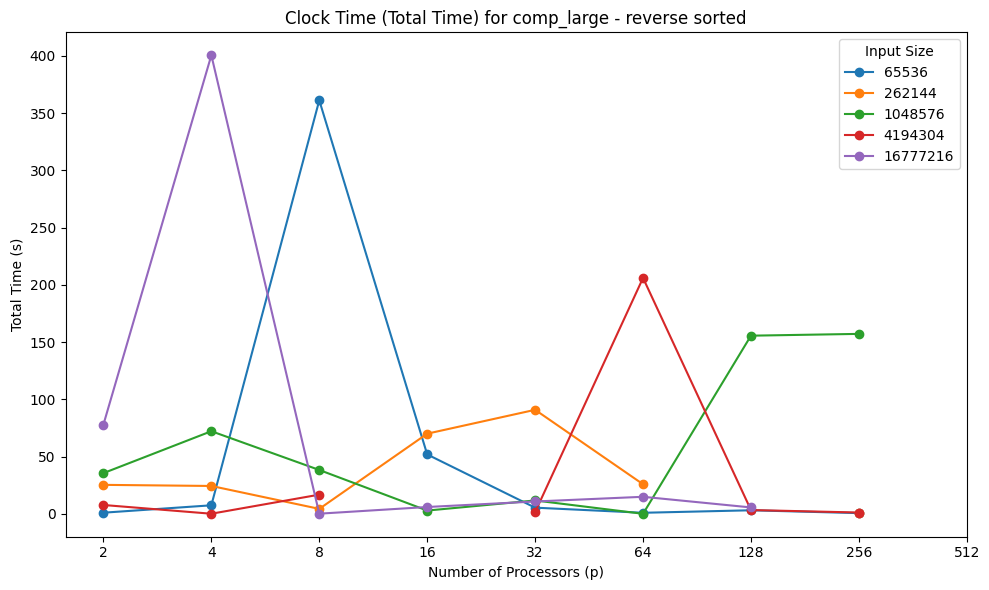

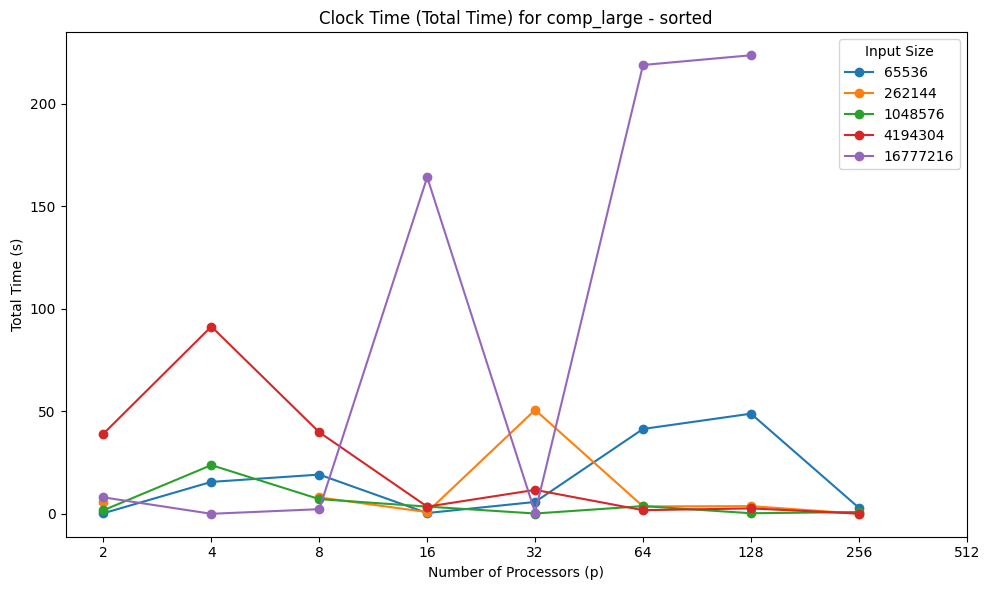

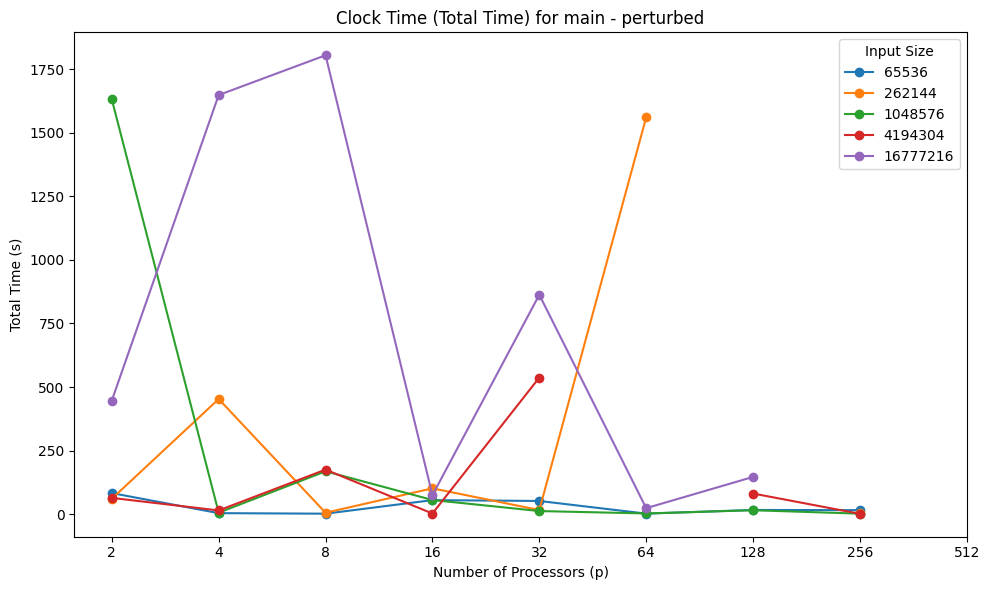

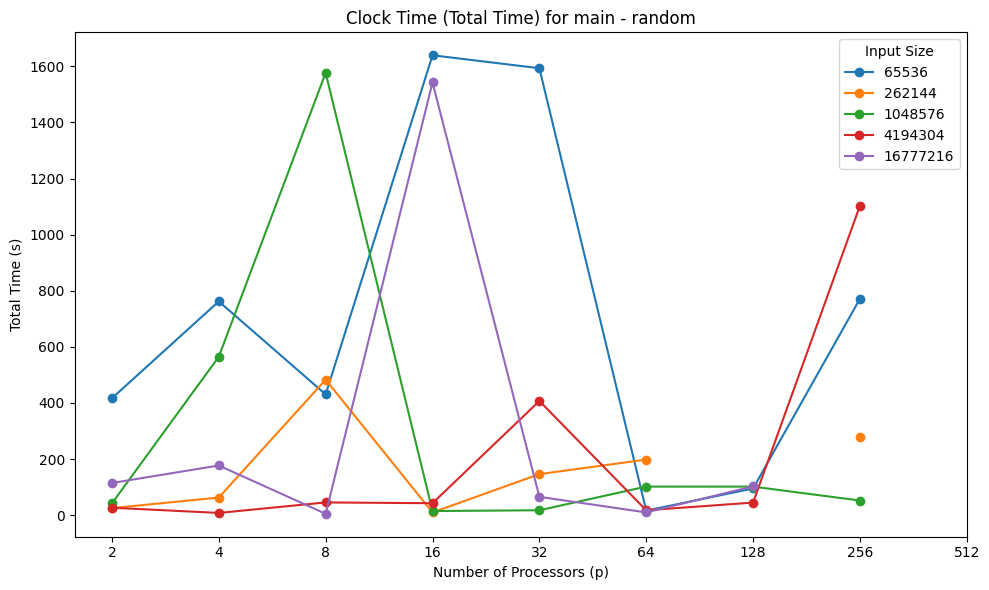

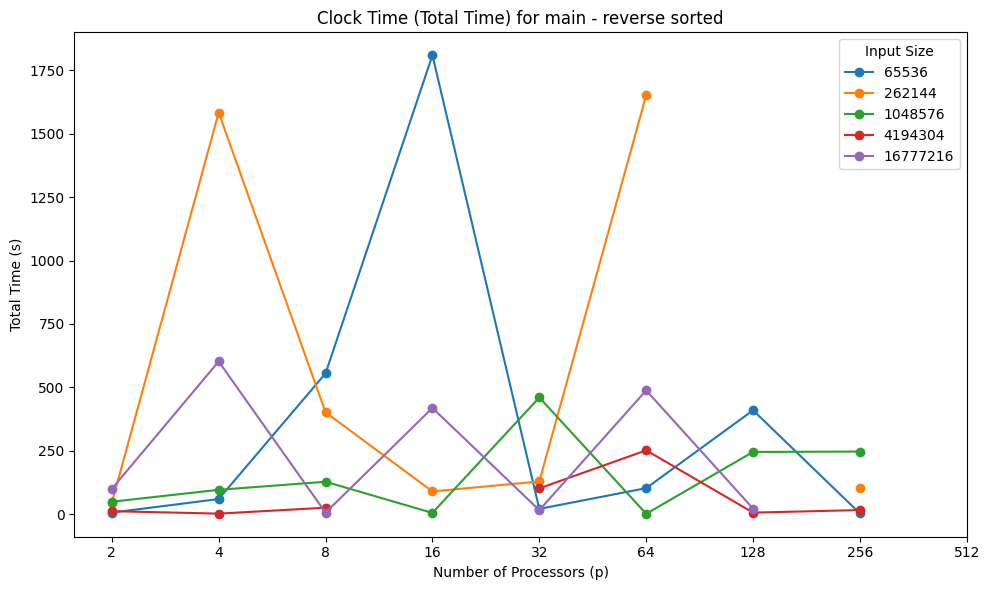

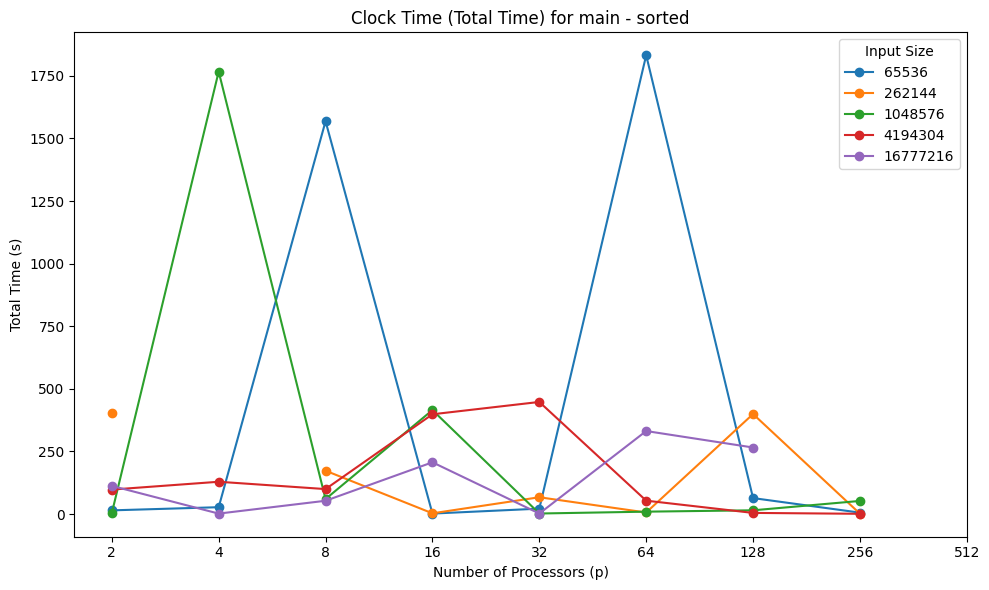

In [476]:
#=======
# AI generated
#=======

def plot_clock_time(dataframe_dict):
    for node_name, df in dataframe_dict.items():
        if node_name not in ['comm', 'main', 'comp_large']:
            continue

        # Define the full range of processor counts you want to show on the x-axis
        full_proc_counts = [2, 4, 8, 16, 32, 64, 128, 256, 512]

        # Iterate over each input type to create separate plots
        for input_type, input_type_group in df.groupby('input_type'):
            fig, ax = plt.subplots(figsize=(10, 6))

            # Plot Total time for each input_size within the same input_type
            for input_size, input_size_group in input_type_group.groupby('input_size'):
                total_times = []

                # Collect Total time for each processor count in full_proc_counts
                for num_procs in full_proc_counts:
                    time_for_procs = input_size_group[input_size_group['num_procs'] == num_procs]['Total time'].mean()
                    total_times.append(time_for_procs if not pd.isna(time_for_procs) else None)

                # Plot the Total time for this input_size
                ax.plot(full_proc_counts, total_times, marker='o', label=f'{input_size}')

            # Formatting the plot
            ax.set_title(f"Clock Time (Total Time) for {node_name} - {input_type}")
            ax.set_xlabel("Number of Processors (p)")
            ax.set_xscale('log', base=2)
            ax.set_ylabel("Total Time (s)")
            ax.set_xticks(full_proc_counts)
            ax.set_xticklabels(full_proc_counts)  # Set x-axis labels to all expected processor counts
            ax.legend(title="Input Size")
            plt.tight_layout()

            # Save the plot with a unique filename
            if SAVE_PLOTS:
                filename = f"Clock_Time_{node_name}_{input_type}.png"
                plt.savefig(f'/content/drive/MyDrive/plots/{filename}', format='png')
                print(f"Saved '{filename}' to /content/drive/MyDrive/plots")

            if PRINT_PLOTS:
                plt.show()

            plt.close(fig)

# Run the function with your dataframe_dict
plot_clock_time(dataframe_dict)